In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import folium

names = ['pandas', 'geopandas', 'numpy', 'matplotlib', 'seaborn', 'folium']

for names, libs in zip(names, [pd, gpd, np, matplotlib, sns, folium]):
    print("{} version : {}".format(names, libs.__version__))

pandas version : 2.0.2
geopandas version : 0.13.2
numpy version : 1.24.4
matplotlib version : 3.7.1
seaborn version : 0.12.2
folium version : 0.14.0


In [2]:
#data includes the shapefile and the covariates file
lead_shp = gpd.read_file('input/GBASE_counties.shp')
lead_data = pd.read_csv('input/GbaseProjectPb.csv')

print(lead_shp.shape)
print(lead_data.shape)

(8, 18)
(2816, 13)


In [4]:
lead_shp.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [5]:
lead_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2816 entries, 0 to 2815
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  2816 non-null   int64  
 1   Y                  2816 non-null   int64  
 2   Pb                 2790 non-null   float64
 3   Elevation          2816 non-null   float64
 4   Slope              2816 non-null   float64
 5   Aspect             2811 non-null   float64
 6   Plan.Curvature     2816 non-null   float64
 7   Profile.Curvature  2816 non-null   float64
 8   TWI                2816 non-null   float64
 9   MRVBF              2816 non-null   float64
 10  MRRTF              2816 non-null   float64
 11  Population         2784 non-null   float64
 12  Landuse            2816 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 286.1 KB


##### ShapeFile description:
In the shapefile the geometry column is what's most important. The columns TYPE_COD0 and DESCRIPT1 contain all NA values.</br> The NAMES column has the county names.
There are a total of 8 entries in the shapefile which corresponds to the 8 councils(i guess) in Glasgow.</br>

##### Lead Data file desciptions:
The lead_data file contains all the covariate information and lead concentration(in ppm). It has a total of 2816 entries with 13 columns.</br> The response Pb column has 26 missing values. (missing value imputation using Moran'I may be?).

The Coordinate Reference system used is EPSG 27700 (British National Grid).

Data Description (lead_data file):

X- Eastings</br>
Y- Northings</br>
Pb- Lead Concentration in ppm</br>
Elevation- Elevation in metres.</br>
Slope, Aspect, Plan.Curvature, Profile.Curvature- more topographical features of locations</br>
TWI- Topographic Wetness Index </br>
MRVBF- Multiresolution Index of Valley Bottom Flatness</br>
MRRTF- Multiresolution Ridge Top Flatness</br>
Population- Population density per $km^2$</br>
Landuse- 21 distinct landuse categories.</br>

##### Questions of Interest:</br>
What is the spatial pattern on Pb contamination in the Glasgow Area?</br>
Are there clusters or hotspots of contamination?</br>
What is the effect of covariates on the Pb spatial pattern?</br>
Where is the contamination predicted to exceed a certain value?</br>


In [6]:
lead_data.describe()

X              Y           Pb    Elevation        Slope  \
count    2816.000000    2816.000000  2790.000000  2816.000000  2816.000000   
mean   260401.471591  664915.534801   174.626237    68.077805     0.055324   
std     12797.319190    7277.486309   318.666547    49.799837     0.047106   
min    221176.000000  649160.000000     8.800000    -1.700000     0.000000   
25%    252255.000000  659550.000000    74.825000    27.000000     0.020613   
50%    261300.000000  664270.000000   116.300000    59.950001     0.042354   
75%    271258.250000  670710.500000   186.800000    95.025000     0.078073   
max    283700.000000  682746.000000  9936.500000   352.899994     0.346812   

            Aspect  Plan.Curvature  Profile.Curvature          TWI  \
count  2811.000000     2816.000000        2816.000000  2816.000000   
mean      3.253587        0.000147          -0.000040     8.792176   
std       1.903244        0.019998           0.000692     0.998087   
min       0.009901       -0.204282          -0.005864     5.352048   
25%       1.570796       -0.004858          -0.000303     8.127327   
50%       3.338987        0.000258          -0.000020     8.746195   
75%       4.957364        0.005372           0.000228     9.390879   
max       6.283185        0.346482           0.004200    12.611724   

             MRVBF        MRRTF    Population      Landuse  
count  2816.000000  2816.000000   2784.000000  2816.000000  
mean      2.341089     1.207270   2370.596983    14.037997  
std       2.102283     1.326463   1801.825704     8.717613  
min       0.000002     0.000005      0.000000     1.000000  
25%       0.498188     0.109871    881.000000     4.000000  
50%       1.833645     0.511704   2252.000000    20.000000  
75%       3.815535     2.058411   3476.000000    21.000000  
max       8.780885     4.990522  11624.000000    21.000000

Negative values for elevation means location below sea level.
Population has minimum of value very close to 0.


In [60]:
lead_data[lead_data.Population < 1]
#map these data later to see where the values correspond to

X       Y     Pb   Elevation     Slope    Aspect  Plan.Curvature  \
2628  273760  649800   68.7  139.399994  0.156816  2.176341        0.010797   
2705  241350  667110   70.9   23.299999  0.036753  1.180189        0.008164   
2713  233770  677710  104.8    6.900000  0.027452  3.324703        0.005990   
2800  258680  672950   60.8   32.099998  0.008062  5.764040       -0.000153   

      Profile.Curvature        TWI     MRVBF     MRRTF  Population  Landuse  
2628           0.001631   8.950227  0.830534  0.041162         0.0        4  
2705           0.000140   8.908380  0.327030  1.704661         0.0        1  
2713          -0.000164   9.406031  1.844041  0.433703         0.0        3  
2800           0.000101  10.923474  4.970794  0.516887         0.0        3

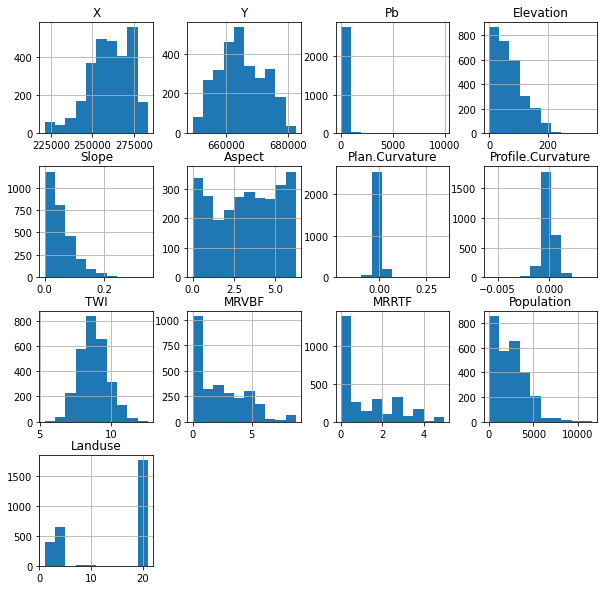

In [158]:
lead_data.hist(figsize=(10, 10))
plt.show()

Insights from Histogram plot:</br>
Pb columns is skewed...needs a closer look.
Same with Population, MRVBF, MRRTF variables. But these are indices related to the features of wetness. Do we need to transform them?
Landuse variable seems to be discrete. Can it be transformed to categorical altogether?

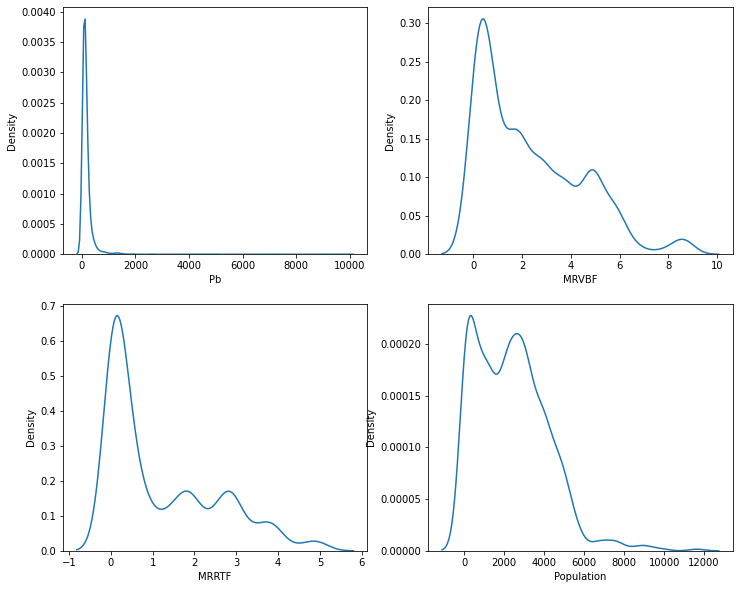

In [54]:
cols= ['Pb', 'MRVBF', 'MRRTF', 'Population']
fig = plt.figure(figsize=(12, 10))
for i in range(len(cols)):
    ax= fig.add_subplot(2, 2, i+1)
    sns.kdeplot(ax= ax, x = cols[i], data = lead_data)
plt.show()

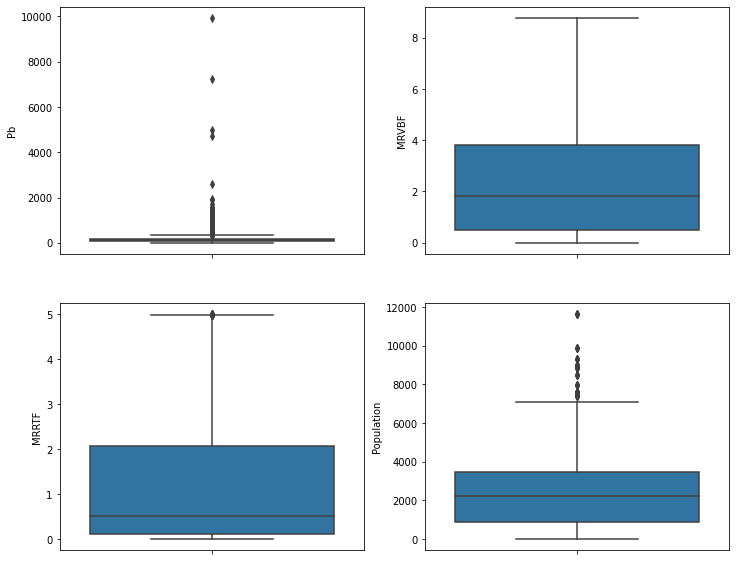

In [55]:
cols= ['Pb', 'MRVBF', 'MRRTF', 'Population']
fig = plt.figure(figsize=(12, 10))
for i in range(len(cols)):
    ax= fig.add_subplot(2, 2, i+1)
    sns.boxplot(ax= ax, y = cols[i], data = lead_data)
plt.show()

In [3]:
#transformations used: log base 2 on Lead, sqrt on Population.
lead_data['log2_Pb'] = np.log2(lead_data['Pb'])
lead_data['sqrt_population'] = np.sqrt(lead_data['Population'])

lead_data.head()

X       Y     Pb   Elevation     Slope    Aspect  Plan.Curvature  \
0  254740  674330  129.7   57.700001  0.027652  0.862170       -0.018001   
1  253550  656420   62.5   89.599998  0.019695  0.418225       -0.001026   
2  254300  673940  126.3   68.300003  0.065420  1.786154       -0.001032   
3  253920  674860   76.9   85.800003  0.055117  2.381830       -0.010032   
4  253210  655720   49.2  134.199997  0.023191  0.129704       -0.015801   

   Profile.Curvature       TWI     MRVBF     MRRTF  Population  Landuse  \
0          -0.000002  9.039945  3.799662  0.016220      3849.0       21   
1           0.000140  8.815510  2.982895  0.082559      3525.0       21   
2          -0.000132  7.998269  1.548909  0.182469      2228.0        3   
3          -0.000006  8.699532  1.844372  0.040104      1453.0        3   
4          -0.000233  8.991853  1.738974  2.153794      3178.0       21   

    log2_Pb  sqrt_population  
0  7.019035        62.040309  
1  5.965784        59.371710  
2  6.980711        47.201695  
3  6.264912        38.118237  
4  5.620586        56.373753

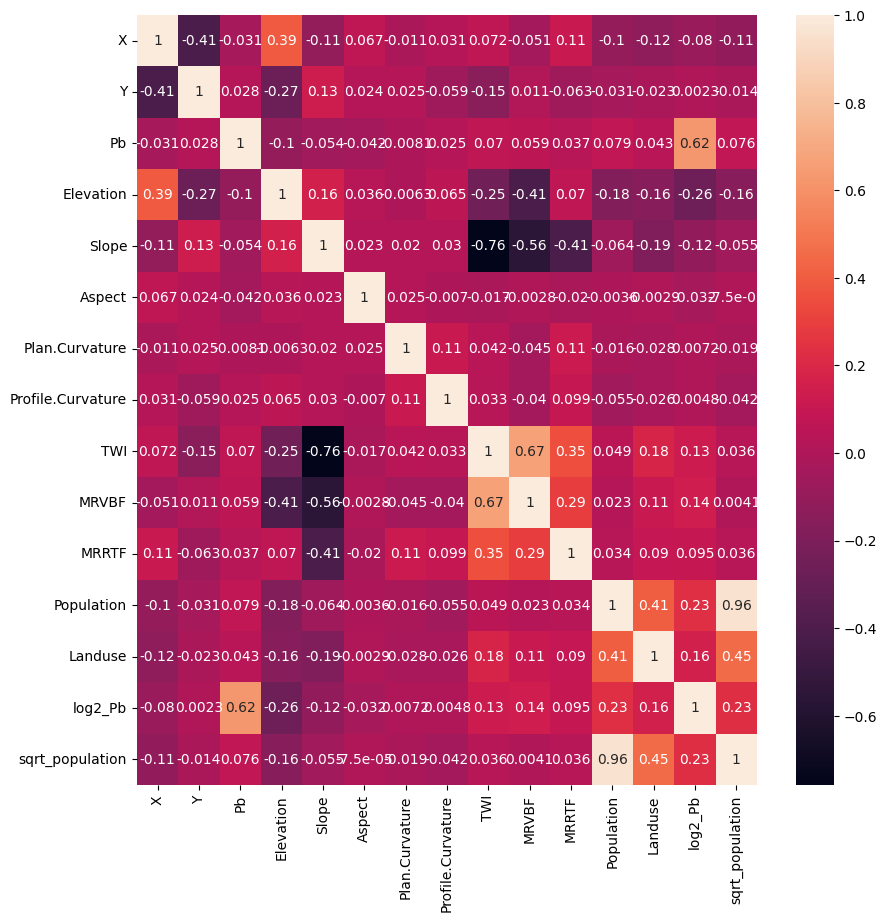

In [6]:
fig= plt.figure(figsize=(10, 10))
sns.heatmap(figure= fig, data = lead_data.corr(), annot= True)
plt.show()

Insights from heatmap:</br>
Correlations are influenced by outliers and skewed data. After addressing them, again plot a heatmap.</br>
log2_Pb seems to be moderately correlated with population, and elevation.

As for correlation between covariates:</br>
Population and Landuse: 0.41 (moderate)</br>
Slope and TWI: -0.76</br>
Elevation and TWI: -0.25</br>
Elevation and MRVBF: -0.41</br>
TWI and MRVBF: 0.67</br>
TWI and MRRTF: 0.35</br>
MRVBF vand MRRTF: 0.29</br>


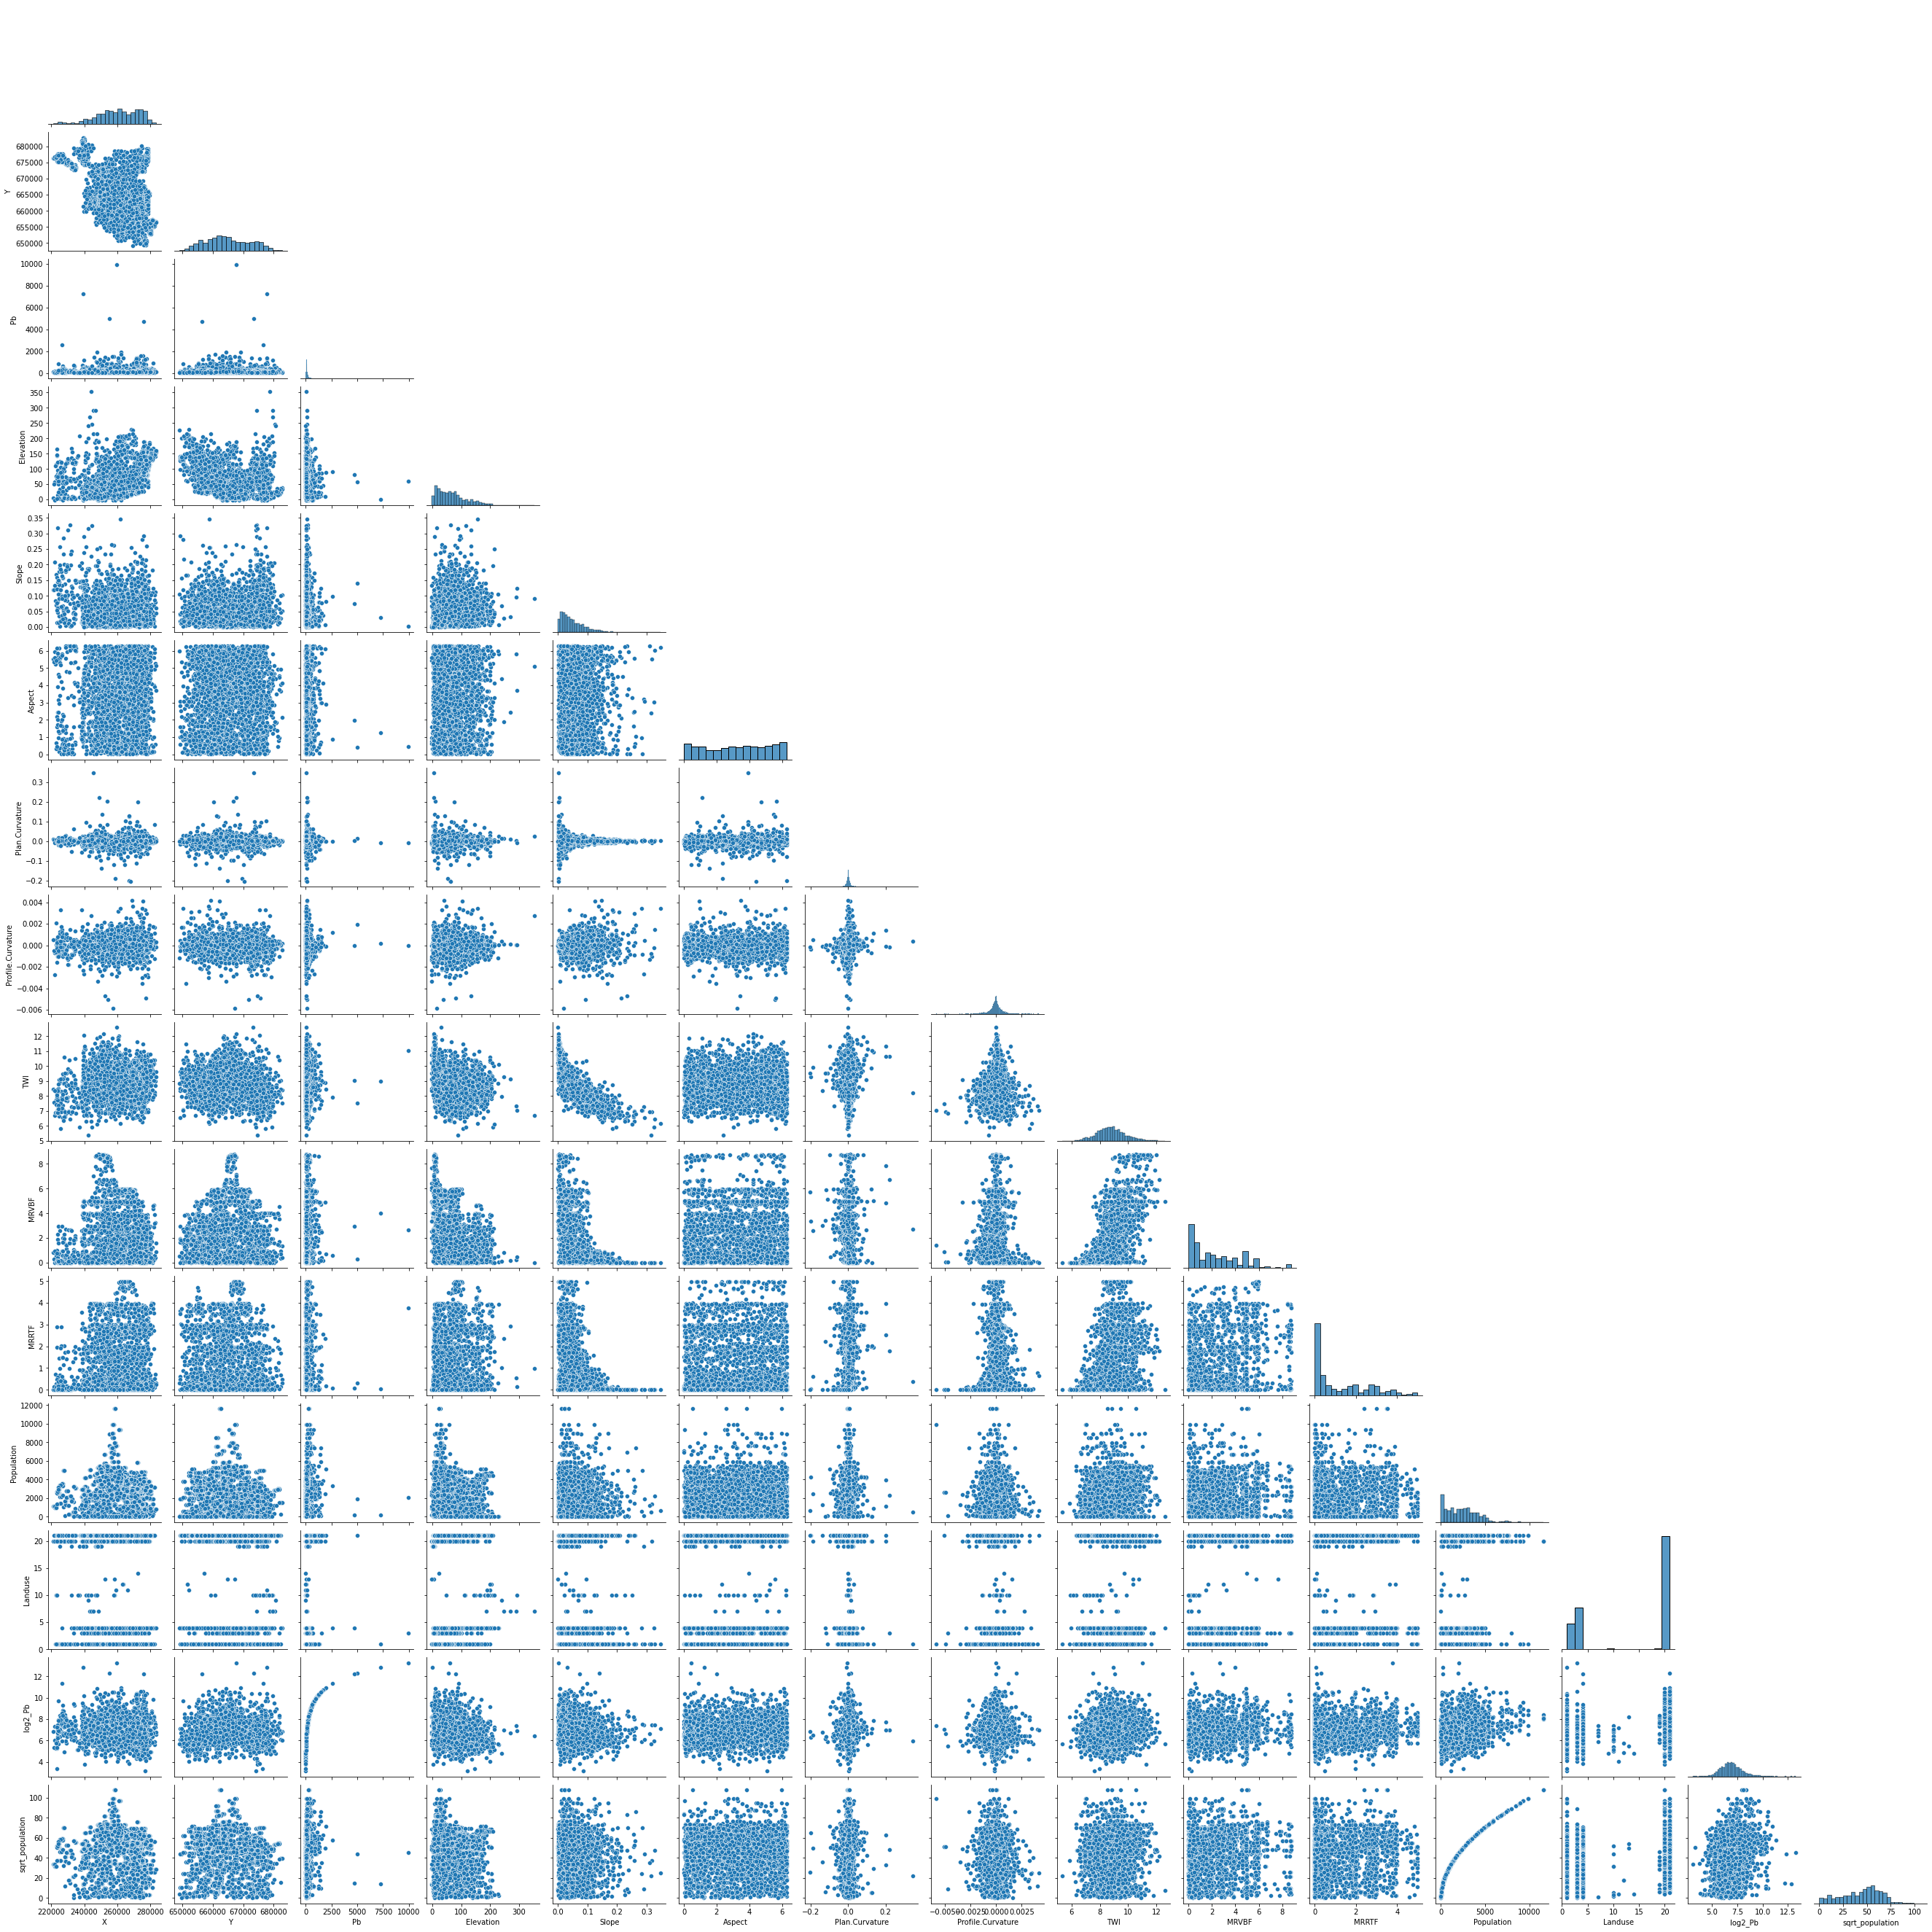

In [12]:
#pair plot
sns.pairplot(data= lead_data, corner = True)
plt.show()

Insights from heatmap and pairplots:
TWI, MRRTF, MRVBF
log2_Pb and Slope


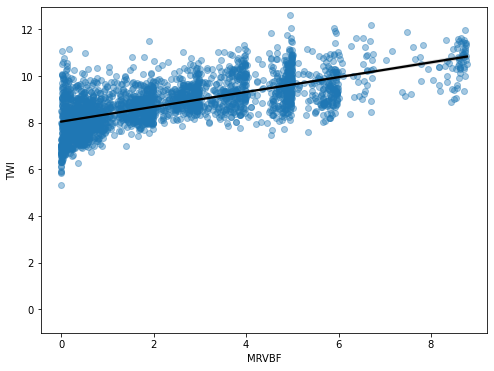

In [66]:
fig, ax = plt.subplots(1, figsize= (8, 6))
sns.regplot(ax= ax, y = 'TWI', x= 'MRVBF', data = lead_data, fit_reg= True,
             scatter_kws=dict(alpha=0.4), line_kws=dict(color='black'))
plt.ylim(bottom= -1)
plt.show()

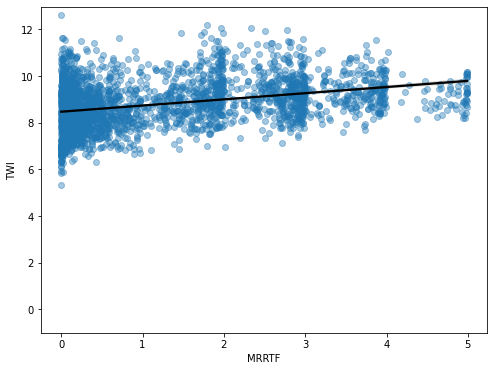

In [67]:
fig, ax= plt.subplots(1, figsize= (8, 6))
sns.regplot(ax= ax, y= 'TWI', x= 'MRRTF', data = lead_data, fit_reg= True,
            scatter_kws=dict(alpha=0.4), line_kws= dict(color='black'))
plt.ylim(bottom= -1)
plt.show()

TWI can be a good stand in for MRRTF and MRVBF variables based on correlation and scatterplots

In [54]:
lead_data[(lead_data.TWI < 6) | (lead_data.TWI >= 12)].sort_values(by = 'TWI')

X       Y     Pb   Elevation     Slope    Aspect  Plan.Curvature  \
2805  242330  674610   49.9   88.300003  0.314945  2.412656        0.002787   
1684  225727  677202  296.1  105.500000  0.184687  5.626837       -0.006007   
2733  237230  679320   41.6  208.300003  0.196984  3.015995        0.003916   
2793  244810  674110   62.8  115.800003  0.325063  3.007668       -0.001695   
910   261190  663710  360.6   10.200000  0.002828  3.926991       -0.017678   
414   239680  675380  215.1    4.200000  0.003162  4.390639        0.003162   
1356  251590  667620  108.9    5.300000  0.002236  4.248742       -0.007155   
2766  259840  673250   50.9   31.799999  0.000000       NaN        0.000000   

      Profile.Curvature        TWI     MRVBF     MRRTF  Population  Landuse  \
2805          -0.000746   5.352048  0.000002  0.000019       482.0        1   
1684           0.003270   5.835144  0.000072  0.002461      1418.0        1   
2733          -0.000643   5.895731  0.002200  0.023480         NaN       10   
2793          -0.000246   5.930999  0.000015  0.000005         NaN        4   
910            0.000050  12.041070  5.909545  2.338960      2159.0       20   
414            0.000110  12.053916  4.960711  1.967984      1370.0       20   
1356          -0.000004  12.170578  6.710470  1.791109      1758.0       20   
2766           0.000000  12.611724  4.946909  0.001167        58.0        4   

       log2_Pb  sqrt_population  
2805  5.640968        21.954498  
1684  8.209941        37.656341  
2733  5.378512              NaN  
2793  5.972693              NaN  
910   8.494256        46.465041  
414   7.748864        37.013511  
1356  6.766860        41.928511  
2766  5.669594         7.615773

No relation between outliers in TWI and unusual values of log2_Pb or Pb variables.

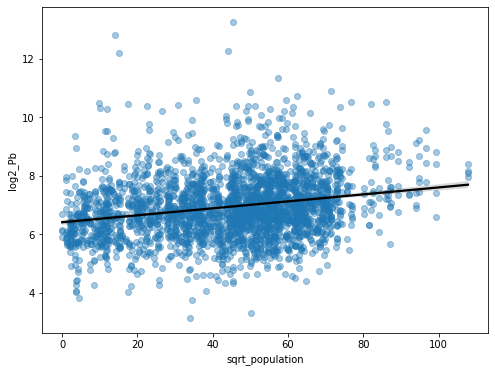

In [59]:
plt.figure(figsize=(8, 6))
sns.regplot(y= 'log2_Pb', x = 'sqrt_population', data= lead_data,
             scatter_kws=dict(alpha=0.4), line_kws=dict(color='black'))
plt.show()

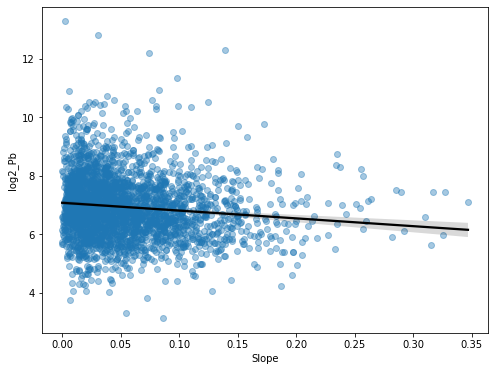

In [63]:
plt.figure(figsize=(8, 6))
sns.regplot(y= 'log2_Pb', x = 'Slope',
            data = lead_data, scatter_kws=dict(alpha= 0.4), line_kws=dict(color= 'black'))
plt.show()

21    1330
4      502
20     408
1      393
3      136
19      18
10      16
7        5
13       2
12       2
11       2
14       1
9        1
Name: Landuse, dtype: int64

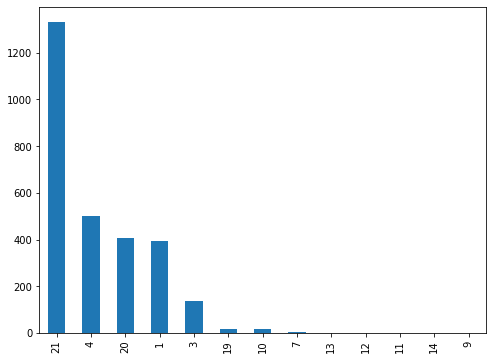

In [13]:
#landuse seemed to be discrete. Value counts will confirm this.
lead_data.Landuse.value_counts().plot(kind= 'bar', figsize= (8,6))
lead_data.Landuse.value_counts()

Variation among Landuse categories remains to be seen. We can do this using scatterplots, boxplots and kdeplots.</br> Some of the categories have low sample size. Thus we can remove this from visual analysis.

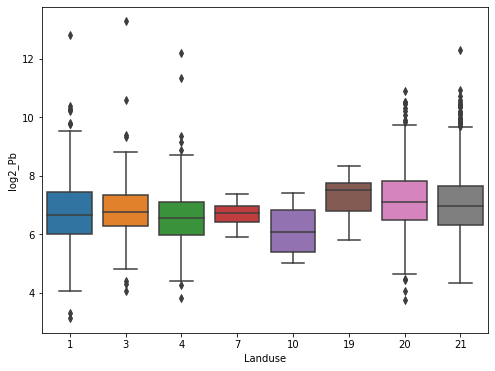

In [14]:
low_sample_landuse= [13, 12, 11, 14, 9]
fig, ax= plt.subplots(1, 1, figsize= (8, 6))
sns.boxplot(ax= ax, y= 'log2_Pb', x= 'Landuse', data = lead_data[~lead_data.Landuse.isin(low_sample_landuse)])
plt.show()

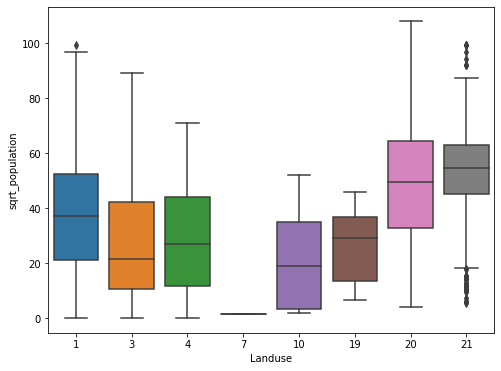

In [15]:
fig, ax= plt.subplots(1, 1, figsize= (8, 6))
sns.boxplot(ax= ax, y = 'sqrt_population', x = 'Landuse', data = lead_data[~lead_data.Landuse.isin(low_sample_landuse)])
plt.show()

Apart from the category 19, the mean log2_Pb of the categories does not seem to be vary much between one another.

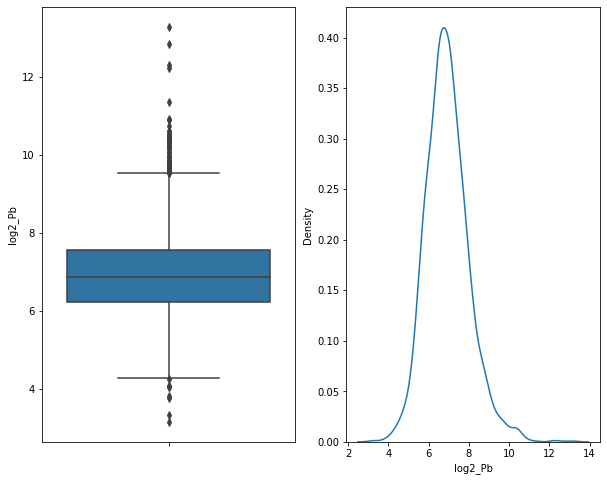

In [76]:
fig, ax= plt.subplots(1, 2, figsize= (10, 8))
sns.boxplot(ax= ax[0], y = 'log2_Pb', data = lead_data)
sns.kdeplot(ax= ax[1], x = 'log2_Pb', data = lead_data)
plt.show()

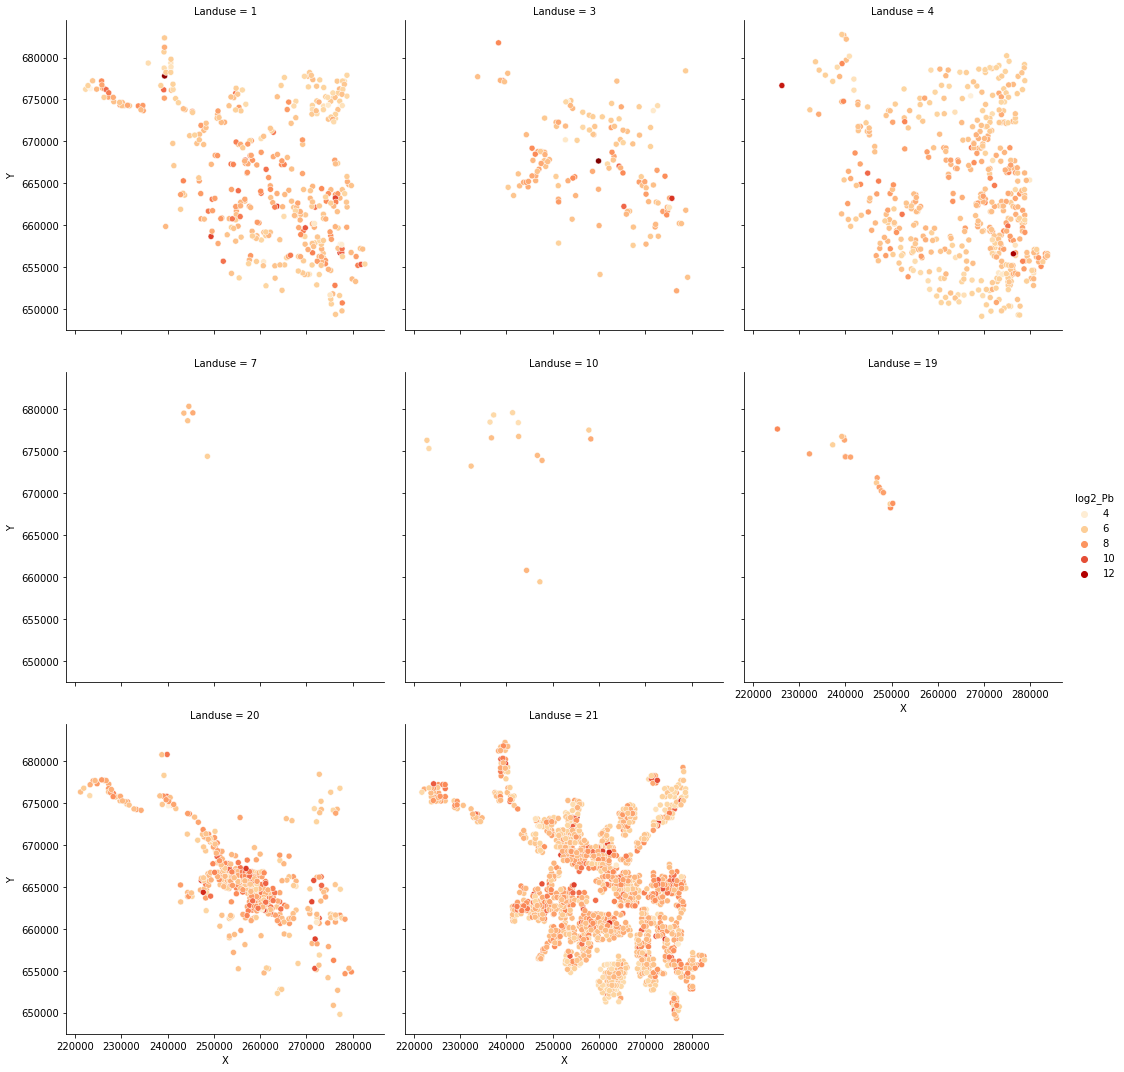

In [20]:
#scatterplot of x,y colorcoded with log2_Pb, and faceted with Landuse
sns.relplot(x = 'X', y = 'Y', data = lead_data[~lead_data.Landuse.isin(low_sample_landuse)],
            hue= 'log2_Pb', col= 'Landuse', col_wrap= 3, palette= 'OrRd')
plt.show()

The small number of outliers distort the color coding. A better plot would be by disregarding the values.

In [7]:
#values above 99.7 percentile and below 0.3 percentile
np.quantile(lead_data.log2_Pb[~lead_data.log2_Pb.isna()], q = [0.003, 0.997])

array([ 4.24380789, 10.60590125])

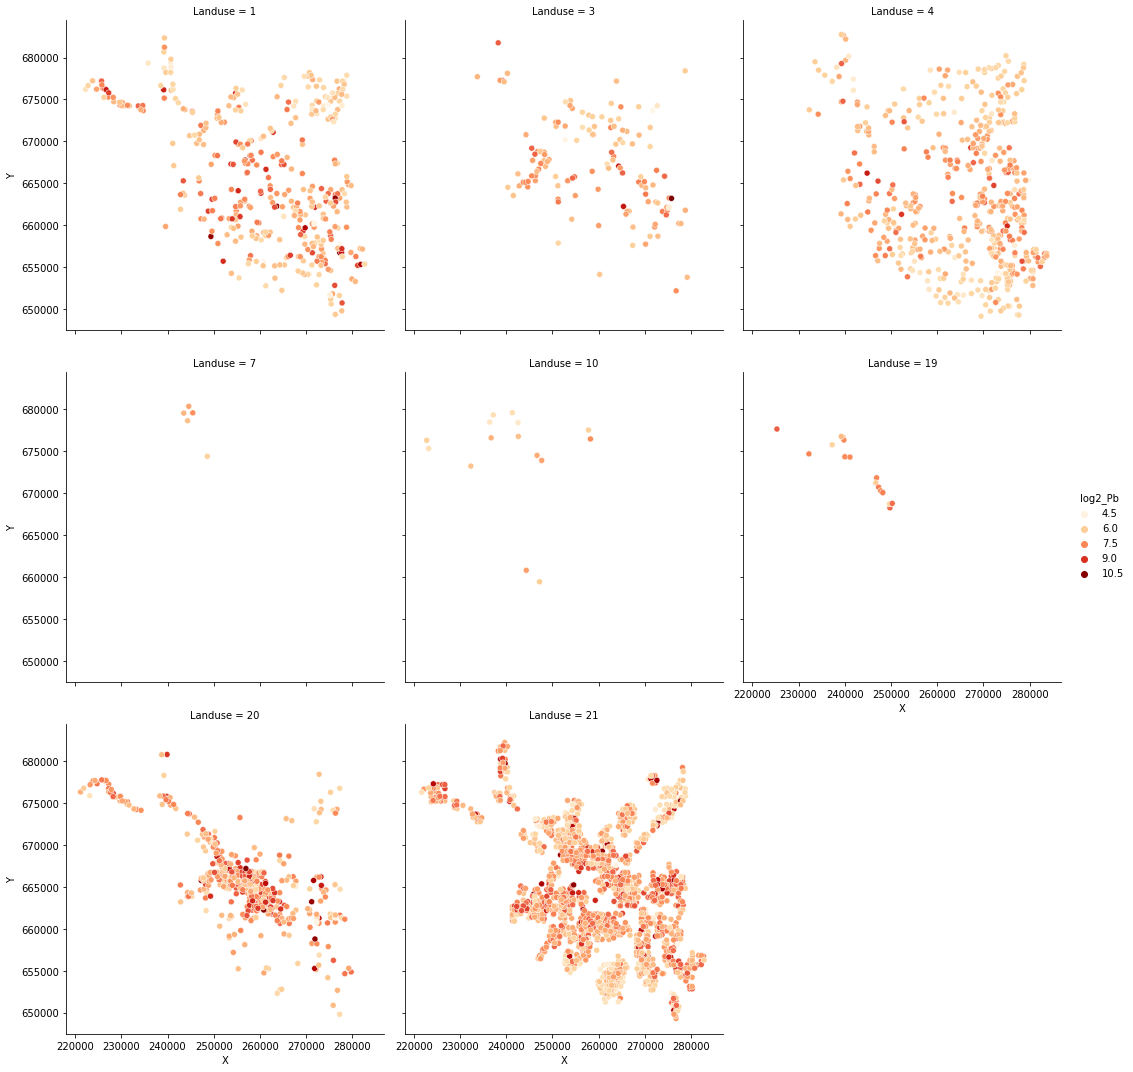

In [34]:
less_noise_lead_data= lead_data[~lead_data.Landuse.isin(low_sample_landuse)]
less_noise_lead_data= less_noise_lead_data[(less_noise_lead_data.log2_Pb >= 4.23) & (less_noise_lead_data.log2_Pb <= 10.605)]
sns.relplot(x = 'X', y = 'Y', data = less_noise_lead_data,
            hue= 'log2_Pb', col= 'Landuse', col_wrap= 3, palette= 'OrRd')
plt.show()

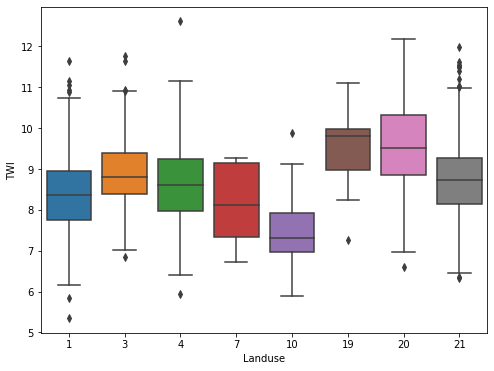

In [37]:
fig, ax = plt.subplots(1, figsize= (8, 6))
sns.boxplot(ax= ax, x = 'Landuse', y = 'TWI', data = less_noise_lead_data)
plt.show()

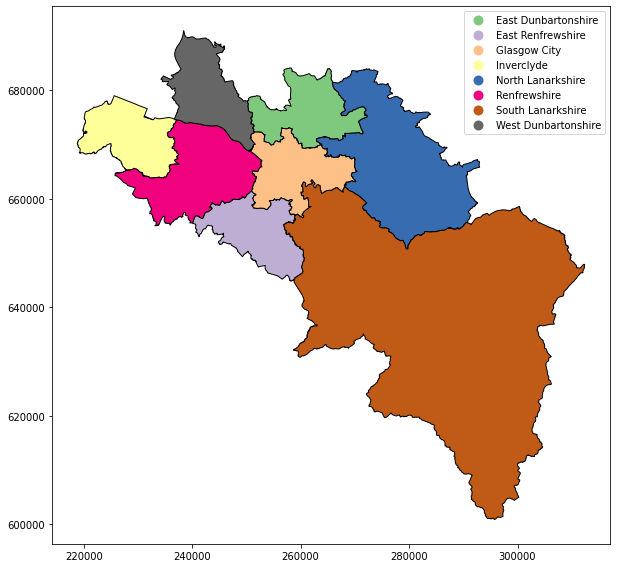

In [64]:
lead_shp.plot(figsize = (10, 10), edgecolor = 'black', column = 'NAME', cmap = 'Accent',
              legend = True)
plt.show()

In [4]:
lead_data_gdf = gpd.GeoDataFrame(lead_data, geometry= gpd.points_from_xy(lead_data['X'], lead_data['Y']), 
                 crs = 27700) #from 27700

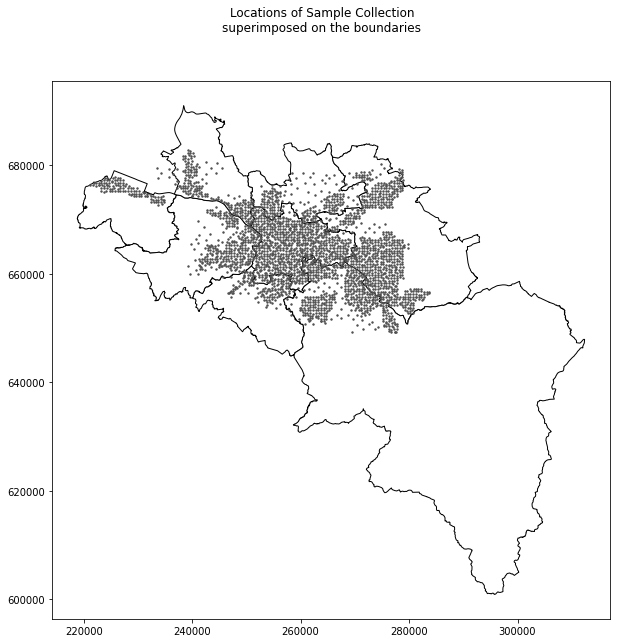

In [75]:
ax = lead_shp.plot(figsize = (10, 10), color = 'white', edgecolor = 'black', zorder = 1)
lead_data_gdf.plot(ax = ax, markersize= 2, color = '#525252')
plt.suptitle('Locations of Sample Collection\nsuperimposed on the boundaries')
plt.show()

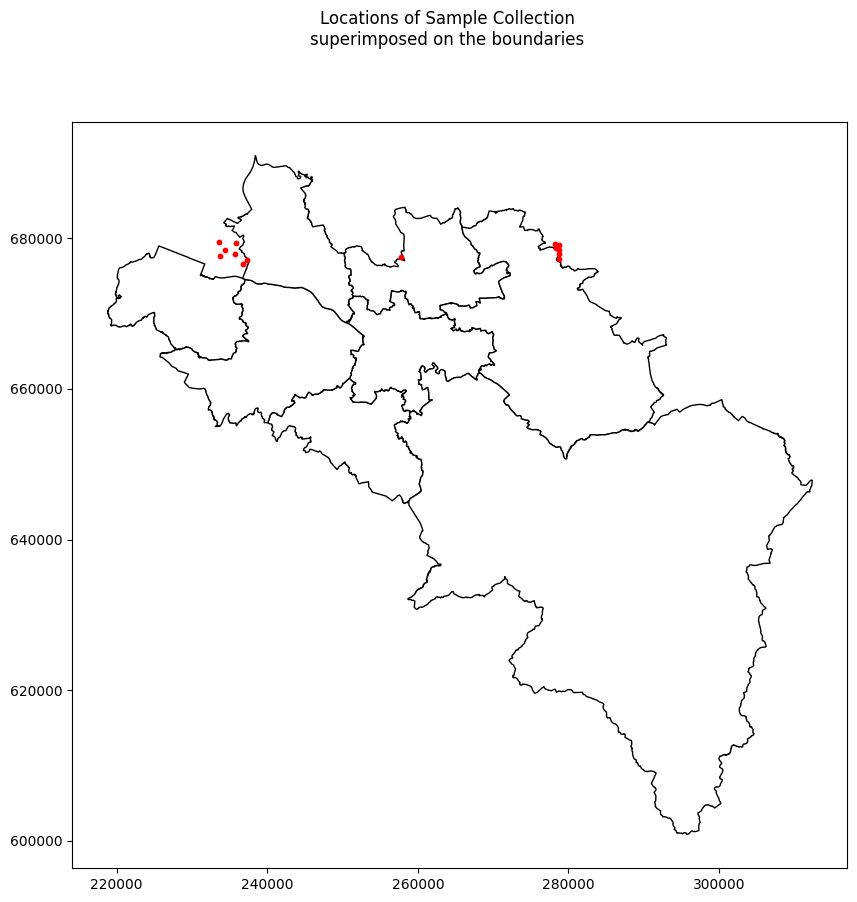

In [21]:
#plot of outside points
ax = lead_shp.plot(figsize = (10, 10), color = 'white', edgecolor = 'black', zorder = 1)
lead_data_gdf.iloc[[1388, 1392, 1413, 1426, 1429, 1435, 1439, 2638, 2672, 2678, 2689, 2713, 2717, 2749, 2755]].plot(ax = ax, markersize= 10, color = 'red')
plt.suptitle('Locations of Sample Collection\nsuperimposed on the boundaries')
plt.show()

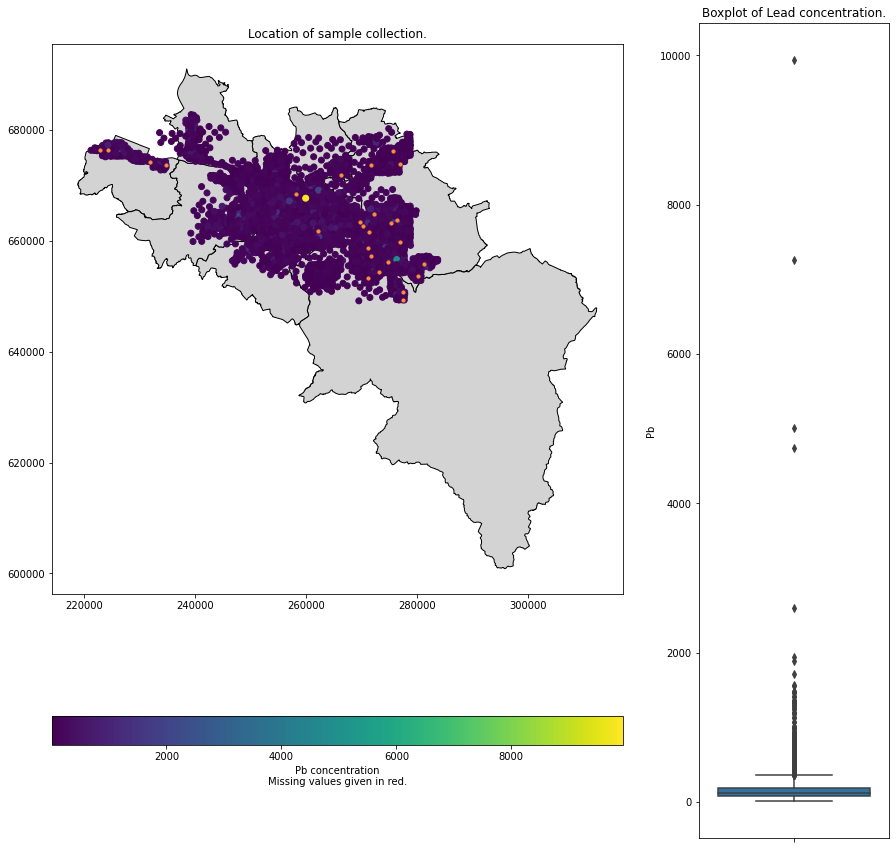

In [79]:
fig, ax= plt.subplots(1, 2, figsize = (15, 15), gridspec_kw= dict(width_ratios= [3, 1]))
lead_shp.plot(ax= ax[0], color = 'lightgray', edgecolor = 'black')
lead_data_gdf.plot(ax = ax[0], column = 'Pb', legend = 'True',
                   legend_kwds= {'label':'Pb concentration\nMissing values given in red.', 'orientation':'horizontal'},
                   missing_kwds= {'color': '#fd8d3c', 'edgecolor':'#fd8d3c', 'label': 'missing values', 'markersize' : 10})
sns.boxplot(y = 'Pb', data = lead_data, ax = ax[1])
ax[0].set_title('Location of sample collection.')
ax[1].set_title('Boxplot of Lead concentration.')
plt.show()

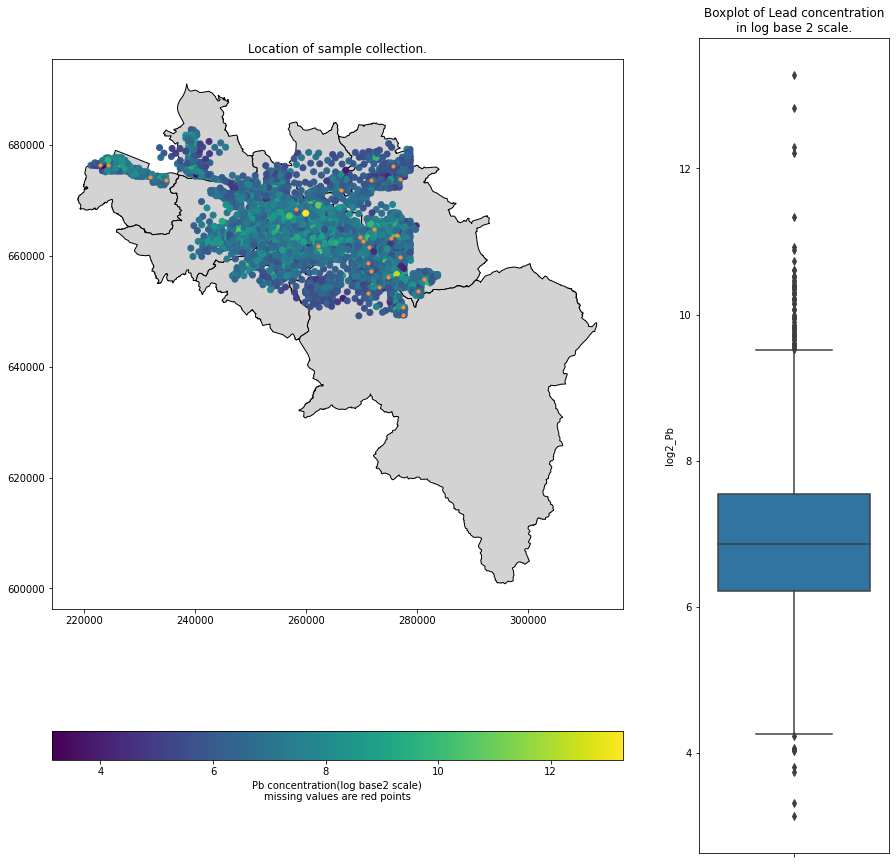

In [81]:
#the same plot but with Pb concentration in log base2 scale
fig, ax= plt.subplots(1, 2, figsize= (15, 15), gridspec_kw=dict(width_ratios= [3, 1]))
lead_shp.plot(ax= ax[0], color = 'lightgray', edgecolor = 'black')
lead_data_gdf.plot(ax = ax[0], column = 'log2_Pb', legend = 'True',
                   legend_kwds= {'label':'Pb concentration(log base2 scale)\nmissing values are red points', 'orientation':'horizontal'},
                   missing_kwds= {'color': '#fd8d3c', 'edgecolor':'#fd8d3c', 'label': 'missing values', 'markersize' : 10})
sns.boxplot(y = 'log2_Pb', data = lead_data, ax = ax[1])
ax[0].set_title('Location of sample collection.')
ax[1].set_title('Boxplot of Lead concentration\nin log base 2 scale.')
plt.show()

Outliers are shifted to another frame and the remaining rows are made into a data frame called 'lead_data_gdf_main'.

In [5]:
from scipy import stats
pb_zscore= stats.zscore(lead_data_gdf.log2_Pb, nan_policy='omit')
pb_zscore_frame= pd.DataFrame({'log2_Pb' : lead_data_gdf.log2_Pb[~lead_data_gdf.log2_Pb.isnull()], 'zscores' : pb_zscore})

pb_zscore_frame.head()

log2_Pb   zscores
0  7.019035  0.082760
1  5.965784 -0.893502
2  6.980711  0.047237
3  6.264912 -0.616239
4  5.620586 -1.213467

In [6]:
#OUTLIERS 
outlier_idx= np.where(np.abs(pb_zscore_frame.zscores) > 3)[0]   #find indices of outlier based on 3 standard deviation rule
lead_data_gdf['is_outlier'] = lead_data_gdf.index.isin(outlier_idx)

lead_data_gdf_outliers= lead_data_gdf[lead_data_gdf.index.isin(outlier_idx)] #outlier rows
lead_data_gdf_main= lead_data_gdf[~lead_data_gdf.index.isin(outlier_idx)] #non outlier rows //also contains the NA values

In [7]:
lead_data_outliers = lead_data[lead_data.index.isin(outlier_idx)]
lead_data_main = lead_data[~lead_data_gdf.index.isin(outlier_idx)]

In [24]:
lead_data_outliers

X       Y      Pb   Elevation     Slope    Aspect  Plan.Curvature  \
37    255240  673350  5001.0   56.200001  0.139327  0.403019        0.012430   
136   249380  658670  1249.8   69.900002  0.080449  0.408149        0.021323   
417   245900  664110  1458.2   11.500000  0.028418  0.685729        0.016643   
442   247700  664350  1891.9    9.800000  0.006083  6.118038       -0.002488   
825   254600  665230  1300.3    9.900000  0.003606  5.300391        0.017068   
866   263650  662270  1341.8   10.200000  0.099396  4.833013       -0.001313   
898   262210  669120  1938.1   87.599998  0.082522  2.884885       -0.001149   
930   252730  668740  1419.1   16.799999  0.026167  3.256469        0.003775   
1283  262270  660700  1708.6   45.299999  0.038257  4.131632        0.012790   
1296  257920  665660  1483.7   21.000000  0.023341  2.969402       -0.001110   
1315  260800  662240  1398.5   16.700001  0.035496  0.564569       -0.041405   
1400  272269  677679  1327.4   70.800003  0.080331  4.824418       -0.016254   
1405  277278  674207     8.8  120.699997  0.085824  5.056195        0.002269   
1418  271701  677789  1350.3   60.599998  0.054031  0.055498        0.000223   
1512  272806  672723  1361.5   71.900002  0.032051  6.220765        0.002350   
1520  277736  675249  1336.5  109.900002  0.019311  3.512483       -0.041361   
1574  239349  677801  7256.4    1.200000  0.030666  1.238737       -0.009074   
1583  239778  679696  1179.5   17.900000  0.016154  1.190290       -0.006403   
1710  226288  676664  2590.9   89.800003  0.098398  0.878652       -0.001158   
1738  223334  676284    10.0  145.800003  0.054352  2.199591        0.006212   
1851  276254  663254  1203.6   84.800003  0.054617  3.836331       -0.026879   
1866  273156  665717  1304.2   99.400002  0.110008  3.694433        0.003651   
1917  275757  663213  1557.0   85.599998  0.044524  2.983825        0.005612   
2036  271169  663220  1185.3   43.099998  0.064316  4.081310        0.007552   
2239  277258  656729  1241.9   86.099998  0.005385  1.951311        0.024332   
2263  274291  658761  1559.3   68.900002  0.076408  5.866287        0.001889   
2290  271885  658782  1272.7   24.000000  0.021021  4.270014       -0.019732   
2318  276327  656603  4736.9   80.400002  0.074187  1.986288        0.003512   
2538  259895  667668  9936.5   59.599998  0.002236  0.463655       -0.007155   
2572  256952  667183  1473.6   40.000000  0.124512  6.146938       -0.001313   

      Profile.Curvature        TWI     MRVBF     MRRTF  Population  Landuse  \
37             0.001959   7.507143  0.260773  0.318784      1937.0       21   
136            0.000437   8.020058  0.051005  0.884760      3042.0        1   
417            0.000606   9.622820  4.713372  1.987142        96.0       21   
442           -0.000085   8.888748  4.919138  2.358013      2495.0       20   
825           -0.000002  11.494457  8.605248  1.932201      5441.0       21   
866            0.000819   8.385111  4.838015  0.036678       510.0        1   
898           -0.000084   8.431082  0.692651  0.168263      5102.0       21   
930            0.000201  10.210202  4.902425  3.463487      6726.0       21   
1283           0.000010   8.942980  0.182098  2.558173      3900.0       21   
1296          -0.000114   9.400835  2.594010  0.846484      5872.0       20   
1315           0.001488   8.762807  0.278509  0.874329       309.0       20   
1400          -0.000507   7.795120  0.843805  0.057734      2439.0       21   
1405          -0.000154   7.585700  0.257542  0.482413      1156.0        1   
1418           0.000725   9.257780  2.384942  1.956064      2140.0       21   
1512          -0.000475   9.142542  4.883525  0.026197       953.0       21   
1520          -0.000461   9.084097  2.577627  0.026335      2620.0       21   
1574           0.000178   8.966908  3.984872  0.050717       194.0        1   
1583           0.000883   7.970474  1.936874  0.021087      2387.0       21   
1710           0.001197   7.9

In [15]:
lead_data_main.head()

X       Y     Pb   Elevation     Slope    Aspect  Plan.Curvature  \
0  254740  674330  129.7   57.700001  0.027652  0.862170       -0.018001   
1  253550  656420   62.5   89.599998  0.019695  0.418225       -0.001026   
2  254300  673940  126.3   68.300003  0.065420  1.786154       -0.001032   
3  253920  674860   76.9   85.800003  0.055117  2.381830       -0.010032   
4  253210  655720   49.2  134.199997  0.023191  0.129704       -0.015801   

   Profile.Curvature       TWI     MRVBF     MRRTF  Population  Landuse  \
0          -0.000002  9.039945  3.799662  0.016220      3849.0       21   
1           0.000140  8.815510  2.982895  0.082559      3525.0       21   
2          -0.000132  7.998269  1.548909  0.182469      2228.0        3   
3          -0.000006  8.699532  1.844372  0.040104      1453.0        3   
4          -0.000233  8.991853  1.738974  2.153794      3178.0       21   

    log2_Pb  sqrt_population  
0  7.019035        62.040309  
1  5.965784        59.371710  
2  6.980711        47.201695  
3  6.264912        38.118237  
4  5.620586        56.373753

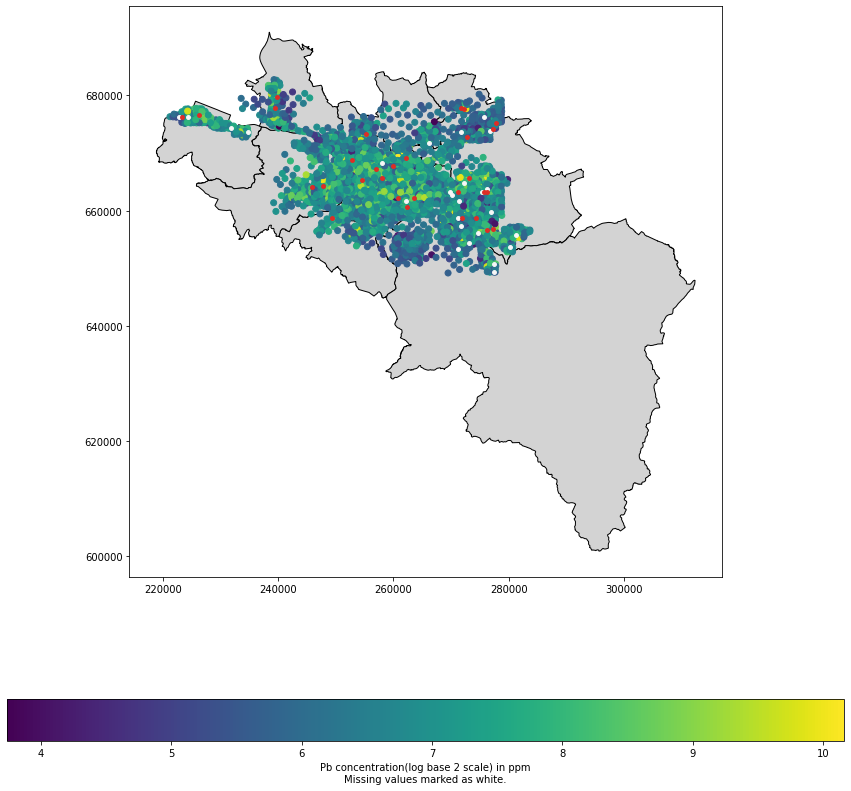

In [139]:
#do the same choropleth maps using log-transformed variable // uses non outlier data frame
ax = lead_shp.plot(figsize=(15, 15), color = 'lightgray', edgecolor = 'black')
lead_data_gdf_main.plot(ax = ax, column = 'log2_Pb', legend= True,
                   legend_kwds= {'label' : 'Pb concentration(log base 2 scale) in ppm\nMissing values marked as white.', 'orientation' : 'horizontal'},
                   missing_kwds= dict(color = '#f7f7f7', markersize= 15))
lead_data_gdf_outliers.plot(ax= ax, color= '#de2d26', markersize= 15, label = 'Outliers')
plt.show()

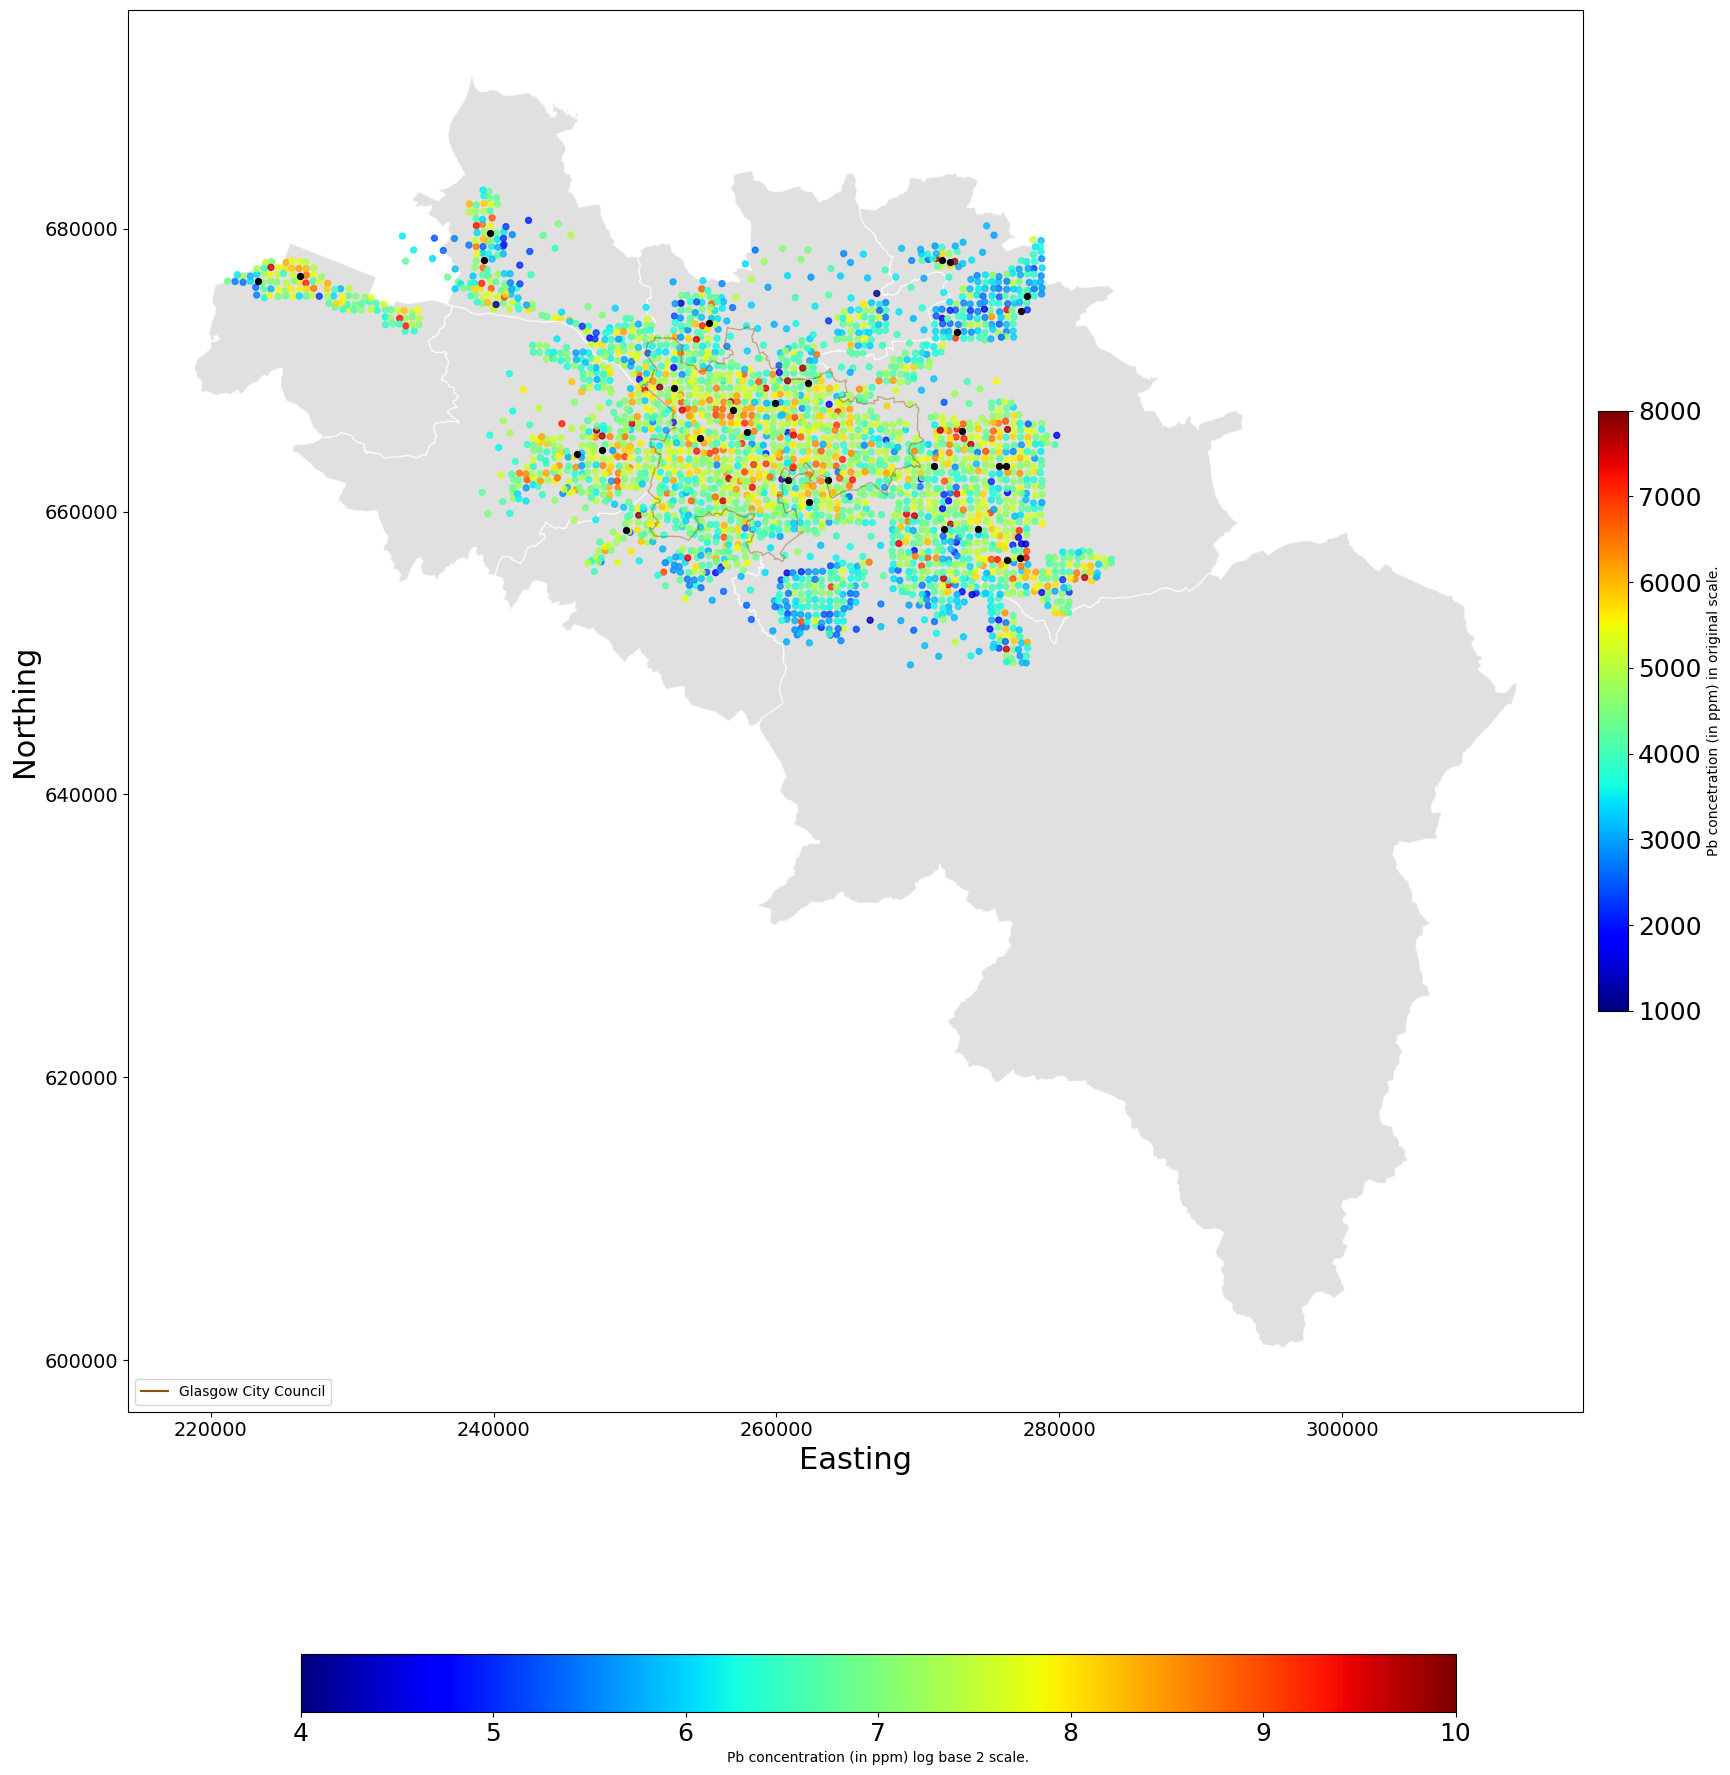

In [54]:
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib import gridspec

fig, ax = plt.subplots(1, figsize = (25, 25))
lead_shp.plot(color = 'lightgrey', edgecolor = 'white', alpha = 0.7, ax= ax)
lead_data_gdf_main.plot(ax = ax, column = 'log2_Pb', markersize= 18, alpha = 0.8, cmap = 'jet')
lead_data_gdf_outliers.plot(ax = ax, color = '#000000', markersize = 18, alpha = 1)
lead_shp[lead_shp.FILE_NAME == 'GLASGOW_CITY'].plot(edgecolor = '#8c510a', facecolor = 'none', ax = ax, alpha = 0.5)

logpb_values = lead_data_gdf_main.log2_Pb
pb_values = lead_data_gdf_main.Pb

cmap = plt.get_cmap('jet')
norm1 = mpl.colors.Normalize(vmin = 4, vmax = 10)
norm2 = mpl.colors.Normalize(vmin = 1000, vmax = 8000)

cbar1 = plt.colorbar(mpl.cm.ScalarMappable(norm = norm1, cmap = cmap),
             orientation = 'horizontal', ax= ax, fraction=0.03, pad = 0.01, label = 'Pb concentration (in ppm) log base 2 scale.')

cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm = norm2, cmap = cmap),
              orientation = 'vertical', ax = ax, fraction = 0.02, pad = 0.01, label = 'Pb concetration (in ppm) in original scale.')

cbar2.ax.tick_params(labelsize = 18)
cbar1.ax.tick_params(labelsize = 18)


plt.xticks(fontsize = 14)
plt.yticks(fontsize =14)

plt.subplots_adjust(left = 0.3)
plt.xlabel('Easting', fontsize = 22)
plt.ylabel('Northing', fontsize = 22)

glasgowcity_border = Line2D([0], [0], label = 'Glasgow City Council', color = '#8c510a')
plt.legend(handles = [glasgowcity_border], loc = 'lower left')
#add figure captions in rmarkdown

plt.show()


In [18]:
dbscan_data = lead_data_main[['X', 'Y', 'log2_Pb']].dropna()
dbscan_data.head()


X       Y   log2_Pb
0  254740  674330  7.019035
1  253550  656420  5.965784
2  254300  673940  6.980711
3  253920  674860  6.264912
4  253210  655720  5.620586

In [69]:
from scipy.spatial import distance_matrix
pd.DataFrame(distance_matrix(dbscan_data, dbscan_data))


0             1             2             3             4     \
0         0.000000  17949.490274    587.962585    976.371122  18672.787739   
1     17949.490274      0.000000  17536.045764  18443.711668    778.203135   
2       587.962585  17536.045764      0.000000    995.389628  18252.575211   
3       976.371122  18443.711668    995.389628      0.000000  19153.164240   
4     18672.787739    778.203135  18252.575211  19153.164240      0.000000   
...            ...           ...           ...           ...           ...   
2755   5042.320943  16328.539436   5254.493357   6017.914922  17102.572920   
2756  19448.766034  23692.422846  19776.440534  20381.658423  24359.690081   
2757   8719.311901  13099.351185   8131.451287   8526.716885  13618.230518   
2758  14858.398304  22162.188530  15235.842613  15758.581793  22896.117597   
2759  11917.587894  20796.098192  12306.746164  12810.323966  21555.799686   

              5             6             7             8             9     \
0     17888.476765    970.051689  18674.691587  18140.002762  18233.005807   
1      1122.942565  18916.839126   2273.785802   1202.206449   4390.182649   
2     17449.415489   1426.359114  18313.590737  17755.207692  17933.298660   
3     18329.847246    921.792627  19262.419443  18687.562711  18912.186617   
4      1161.809008  19638.910451   2490.321475   1591.006244   4775.825074   
...            ...           ...           ...           ...           ...   
2755  16581.875650   5603.570425  16453.027167  16188.196319  15442.878697   
2756  24546.602622  19736.334538  22352.413825  22837.972765  20161.002004   
2757  12536.347208   9396.009799  14731.833107  13816.862900  15419.043436   
2758  22854.846321  15056.593269  21239.183226  21501.797599  19300.582934   
2759  21378.842345  12101.475227  20145.123522  20266.647488  18411.909295   

      ...          2750          2751          2752          2753  \
0     ...  15723.212158  17118.285590  10474.717229  10335.032730   
1     ...  20749.486743  21846.677094  18218.257326  14112.848942   
2     ...  16028.802217  17434.202059   9969.493515   9751.820426   
3     ...  16668.920181  18058.377564   9802.203837   9999.720194   
4     ...  21456.420960  22538.751075  18667.161009  14549.147980   
...   ...           ...           ...           ...           ...   
2755  ...  10850.917012  12274.921600  14616.624101  13286.342753   
2756  ...   3818.861097   2377.603958  29176.716750  27289.499866   
2757  ...  21394.807801  22830.192771   5395.340710   2100.595429   
2758  ...   2467.103591   3056.681322  24921.928103  23432.398568   
2759  ...   4490.267266   5635.689844  22064.387597  20745.476748   

              2754          2755          2756          2757          2758  \
0     10117.114246   5042.320943  19448.766034   8719.311901  14858.398304   
1     16703.035654  16328.539436  23692.422846  13099.351185  22162.188530   
2     10342.596415   5254.493357  19776.440534   8131.451287  15235.842613   
3     11089.458959   6017.914922  20381.658423   8526.716885  15758.581793   
4     17466.041347  17102.572920  24359.690081  13618.230518  22896.117597   
...            ...           ...           ...           ...           ...   
2755   5088.123427      0.000000  14639.142736  11278.980483  10310.819564   
2756   9791.286949  14639.142736      0.000000  25191.770490   4914.682086   
2757  15449.841454  11278.980483  25191.770490      0.000000  21365.317697   
2758   6105.735023  10310.819564   4914.682086  21365.317697      0.000000   
2759   4110.048672   7501.793130   7772.592900  18704.579696   2956.704331   

              2759  
0     11917.587894  
1     20796.098192  
2     12306.746164  
3     12810.323966  
4     21555.799686  
...            ...  
2755   7501.793130  
2756   7772.592900  
2757  18704.579696  
2758   2956.704331  
2759      0.000000  

[2760 rows x 2760 columns]

In [78]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 5000, min_samples = 5)
dbscan.fit(dbscan_data)

DBSCAN(eps=5000)

In [79]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

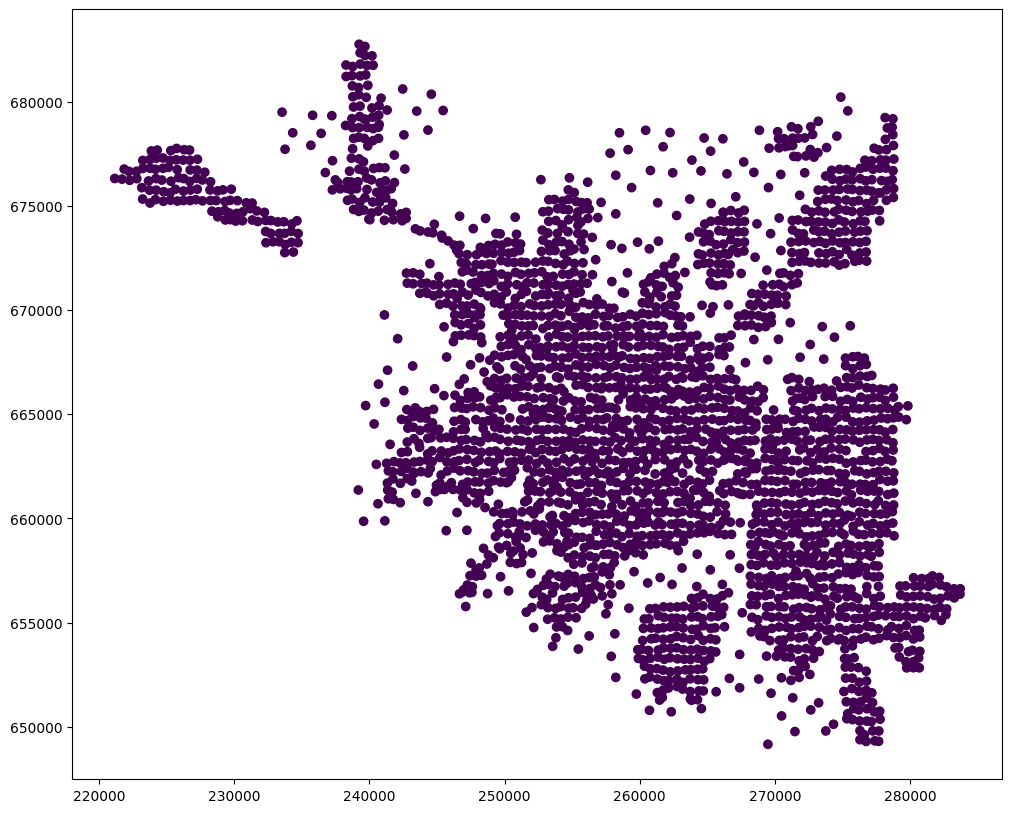

In [80]:
plt.figure(figsize = (12, 10))
plt.scatter('X', 'Y', data = dbscan_data, c = dbscan.labels_)
plt.show()